In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/home/jma819/post_cmfe_analysis')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf
import scipy.spatial.distance as dist
import itertools

/home/jma819/.conda/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
reload(dlc_utils)
reload(utils_jjm)

<module 'python_utils_jjm' from '/home/jma819/post_cmfe_analysis/python_utils_jjm.py'>

In [3]:
#load and prep data
dir_path_cnmfe = '/projects/p30771/MATLAB/CNMF_E_jjm/quest_MATLAB_cnmfe/batch_output_files/29-Mar_21_42_20_out.mat'
dir_path_tracking = '/projects/p30771/dlc_analysis/openfield_dlc_output/GRIN018_H17_M41_S43/GRIN018_H17_M41_S43_dlc_tracking_foranalysis_04142020.csv'

In [4]:
#spatial components
com_df, spatial_components = utils_jjm.return_spatial_info(dir_path_cnmfe, 0.6)

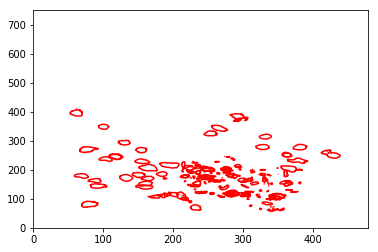

In [5]:
#spatial contours
cell_contours, x, y = utils_jjm.create_contour_layouts(spatial_components)
##if plotting
to_plot = np.array(list(cell_contours.values()))
for i in range(len(to_plot)):
    plt.contour(y, x, to_plot[i], [0.6], colors='r')

In [6]:
# temporal and tracking data
C_z_scored, interpolated = utils_jjm.prepare_timedelta_dfs(dir_path_cnmfe, dir_path_tracking)

In [ ]:
interpolated.head()

In [ ]:
# plotting individual cell fluorescence 
plt.plot(C_z_scored[5][0:4000])
plt.show()

## individual cell regression

In [ ]:
## inputs are downsampling interval, number of bins, body part to use for velocity correlation, velocity dataframe, fluorescence dataframe 
cells_C_binned_by_V, cells_mean_C_binned_by_V = dlc_utils.downsample_session_and_bin_C_by_V(1, 50, 'centroid', interpolated, C_z_scored)

In [ ]:
regression_results = dlc_utils.create_regression_models_per_cell(cells_mean_C_binned_by_V, 2)

In [ ]:
regression_results[2]['statsmodel_results'].summary()

In [ ]:
print(regression_results[cell]['statsmodel_results'].summary().tables[0][0][3].data)

In [ ]:
cell=4
#label
print(regression_results[cell]['statsmodel_results'].summary().tables[0][3][2].data)
#F-stat
print(regression_results[cell]['statsmodel_results'].summary().tables[0][3][3].data)
xp, p1d = dlc_utils.plot_cell_regression(regression_results, cell, cells_mean_C_binned_by_V)
fig = plt.plot(regression_results[cell]['fit_df']['x'].values, regression_results[cell]['fit_df']['y'].values, '.',
              xp, p1d(xp), '--')


In [ ]:
F_stats = np.array([float(regression_results[cell]['statsmodel_results'].summary().tables[0][3][3].data) for cell in range(1, len(regression_results)+1)])

In [ ]:
# to determine cells with significant quadratic regressions
len(np.argwhere(F_stats<0.05))

## plotting event averages

In [ ]:
## plot downsampled velocity 
# plotting "interpolated velocity"
interpolated_indicies=(0,4000)
plt.plot(interpolated['msCam_index'][interpolated_indicies[0]:interpolated_indicies[1]], interpolated['tail_base'][interpolated_indicies[0]:interpolated_indicies[1]])
plt.show()

# downsample velocity and pick maximum values within 200msec 
new_sampling_interval = 2
interpolated = interpolated.set_index(pd.to_timedelta(np.linspace(0, len(interpolated)*(1/20), len(interpolated)), unit='s'), drop=True)
interpolated_downsampled = interpolated.resample(str(new_sampling_interval)+'S').max()


In [ ]:
binned_velocity = dlc_utils.bin_by_activity_threshold(interpolated['tail_base'], 40, 20, 0.5, 0.5)

In [ ]:
plt.plot(binned_velocity[indicies[0]:indicies[1]])

In [ ]:
#return inidicies where velocity transitions from at least a 1 second resting period 
transition_indicies = []
resting_threshold = 40
for point in range(resting_threshold, len(binned_velocity)):
    if binned_velocity[point]>0.5 and not any(binned_velocity[point-resting_threshold:point]):
           transition_indicies.append(point)

In [ ]:
#select section of trace 2 seconds around transition periods
transition_activity = {}
for index in transition_indicies:
       transition_activity[index] = C_z_scored.mean(axis=0)[index-40:index+40]
threshold_activity_df = pd.DataFrame(transition_activity)

In [ ]:
plt.plot(threshold_activity_df.mean(axis=1))
plt.show()

In [ ]:
plt.plot(C_z_scored.mean(axis=0)[indicies[0]:indicies[1]])

In [ ]:
#return indicies where value is above threshold
moving_indicies = np.argwhere(binned_velocity>0.5)
#compare df/f for moving and nonmoving periods 
df_f_moving = np.mean(C_z_scored.mean(axis=0)[moving_indicies])
df_f_resting = np.mean(C_z_scored.mean(axis=0)[np.argwhere(binned_velocity[0:25000]<0.5)])

In [ ]:
np.mean(C_z_scored.mean(axis=0)[moving_indicies])

In [ ]:
np.mean(C_z_scored.mean(axis=0)[np.argwhere(binned_velocity[0:25000]<0.5)])

## spatial clustering 

In [7]:
# get euclidean distances between cells
# need to redo indicies so they are cell numbers, not indicies from com array
pairwise_euclidean_distance = {}
for pair in itertools.combinations(range(1, len(com_df)+1),2):
    pairwise_euclidean_distance[pair] = dist.euclidean(com_df.loc[pair[0]], com_df.loc[pair[1]])    
    #print(pair)
pairwise_distance = pd.DataFrame(pairwise_euclidean_distance, index=['euclidean distance'])

In [8]:
pairwise_distance

1                                                 \
                           2           3          4           5         6     
euclidean distance  101.358911  158.818802  64.356977  170.389634  84.50063   

                                                                    \
                           7           8           9           10    
euclidean distance  186.496933  321.153874  112.026391  191.246868   

                                ...        144                        \
                           11   ...        145        146        147   
euclidean distance  148.043154  ...  25.109004  48.456518  42.060579   

                                     145                              146  \
                          148        146        147        148        147   
euclidean distance  50.512261  27.735483  40.442635  47.670068  66.119355   

                                   147  
                         148       148  
euclidean distance  72.26151  8.453097  

[1 rows x 10878 columns]

In [9]:
C_z_scored_binned = C_z_scored.apply(utils_jjm.binning_function_uncrop, args=[20, 2])
C_z_scored_binned.drop(['msCamFrame'], axis=1, inplace=True)

In [26]:
# get linear pairwise correlation coefficients
pairwise_r_correlation_unbinned = {}
for pair in itertools.combinations(range(1, len(com_df)+1),2):
    pairwise_r_correlation_unbinned[pair] = stats.pearsonr(C_z_scored_binned[pair[0]], C_z_scored_binned[pair[1]])[0]

pairwise_pearson = pd.DataFrame(pairwise_r_correlation_unbinned, index=['pairwise_pearson_r'])


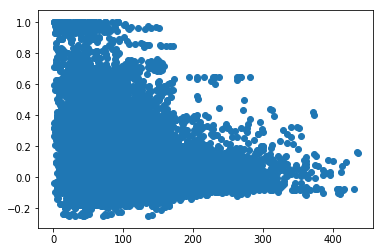

In [27]:
plt.scatter(pairwise_distance.values[0], pairwise_pearson.values[0])
plt.show()

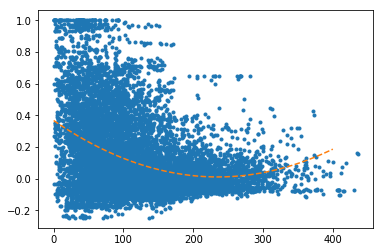

In [54]:
## fit regression
deg = 2
fit_data = pd.DataFrame(columns=['y', 'x'])
fit_data['y'] = pairwise_pearson.values[0]
fit_data['x'] = pairwise_distance.values[0]

p1d = np.poly1d(np.polyfit(fit_data['x'].values, fit_data['y'].values, deg))
model = np.poly1d(np.polyfit(fit_data['x'].values, fit_data['y'].values, deg))
results = smf.ols(formula='y ~ model(x)', data=fit_data).fit()

xp = np.linspace(0, 400, 400)
fig = plt.plot(fit_data['x'].values, fit_data['y'].values, '.',
              xp, p1d(xp), '--')

In [53]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1509.
Date:                Sun, 19 Apr 2020   Prob (F-statistic):          2.51e-309
Time:                        23:02:28   Log-Likelihood:                 138.31
No. Observations:               10878   AIC:                            -272.6
Df Residuals:                   10876   BIC:                            -258.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.176e-16      0.004   1.03e-13      1.000      -0.008       0.008
model(x)       1.0000      0.026     38.852      0.000       0.950       1.050
==============================================================================
Omnibus:                     1517.034   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2331.156
Skew:                           0.995   Prob(JB):                         0.00
Kurtosis:                       4.088   Cond. No.                         11.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# get indicies of interpolated dataframe where mouse is moving 
indicies_to_match = interpolated.iloc[0:len(C_z_scored_binned)][interpolated.iloc[0:len(C_z_scored_binned)]['centroid']>10].index

In [41]:
C_z_scored_moving = C_z_scored_binned.iloc[[interpolated.index.get_loc(value) for value in indicies_to_match]]

In [55]:
#C_z_scored_moving

In [43]:
#plt.plot(interpolated['centroid'].values[0:200])
#plt.show()

In [44]:
#interpolated.loc['00:00:03.550000']

In [45]:
# get linear pairwise correlation coefficients
pairwise_r_correlation_unbinned_moving = {}
for pair in itertools.combinations(range(1, len(com_df)+1),2):
    pairwise_r_correlation_unbinned_moving[pair] = stats.pearsonr(C_z_scored_moving[pair[0]], C_z_scored_moving[pair[1]])[0]

pairwise_pearson_moving = pd.DataFrame(pairwise_r_correlation_unbinned_moving, index=['pairwise_pearson_r'])


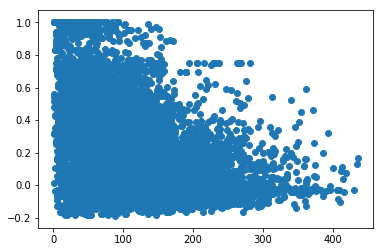

In [39]:
plt.scatter(pairwise_distance.values[0], pairwise_pearson_moving.values[0])
plt.show()

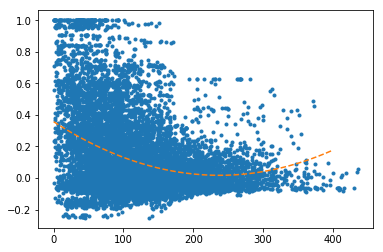

In [58]:
## fit regression
deg = 2
fit_data = pd.DataFrame(columns=['y', 'x'])
fit_data['y'] = pairwise_pearson_moving.values[0]
fit_data['x'] = pairwise_distance.values[0]

p1d = np.poly1d(np.polyfit(fit_data['x'].values, fit_data['y'].values, deg))
model = np.poly1d(np.polyfit(fit_data['x'].values, fit_data['y'].values, deg))
results = smf.ols(formula='y ~ model(x)', data=fit_data).fit()

xp = np.linspace(0, 400, 400)
fig = plt.plot(fit_data['x'].values, fit_data['y'].values, '.',
              xp, p1d(xp), '--')

In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     1377.
Date:                Sun, 19 Apr 2020   Prob (F-statistic):          6.36e-284
Time:                        23:06:58   Log-Likelihood:                 152.51
No. Observations:               10878   AIC:                            -301.0
Df Residuals:                   10876   BIC:                            -286.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.516e-16      0.004   8.29e-14      1.000      -0.008       0.008
model(x)       1.0000      0.027     37.109      0.000       0.947       1.053
==============================================================================
Omnibus:                     1721.668   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2808.061
Skew:                           1.074   Prob(JB):                         0.00
Kurtosis:                       4.256   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""